# Lasso coefficients comparison
---
***Objective:*** The objetive of this notebook is to apply the Lasso regression with several kinds of priors and compare it's coefficients.

***Author:*** Bruno G. de Oliveira

### 1) Importing packages

In [1]:
import sys 
sys.path.append('../')

# Data manipulation 
import pandas as pd 
import numpy as np 
pd.options.display.max_rows=None

# Dataset creation
from dataset.generate_regression_data import RegressionData

# Probabilistic programming
import pymc3 as pm 
import theano as T
from models.bayesian_lasso import bayesian_lasso_regression

# Data visualization
import matplotlib.pyplot as plt 
import seaborn as sns 

%matplotlib inline 

### 2) Create toy dataset

This dataset is built from standard normal distribution where the first five features have non zero coefficients.

In [2]:
args = {
    'n_samples': 100,
    'n_features': 10,
    'nonzero_features': 4,
    'seed': 42
}

In [3]:
data = RegressionData(args)
X, y, coefs = data.generate()

In [4]:
X.shape

(100, 10)

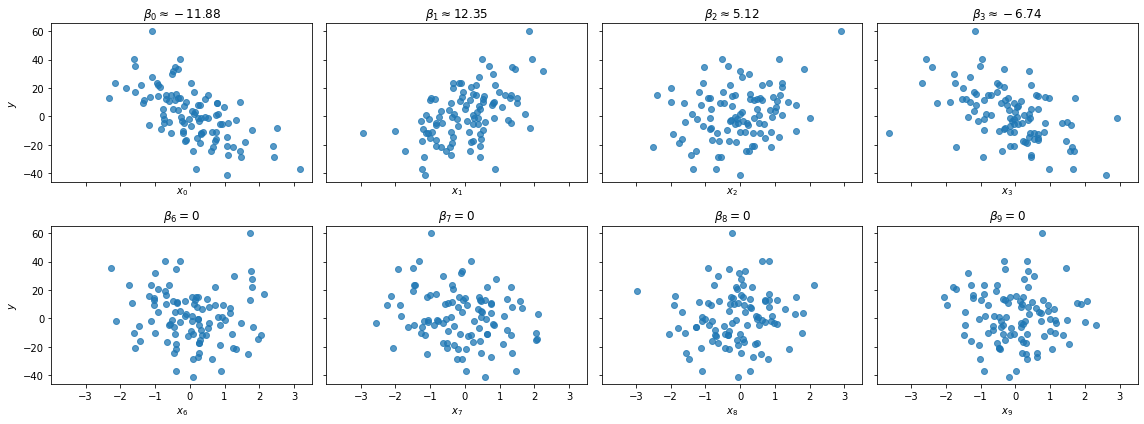

In [5]:
_ = data.plot(X, y, coefs)

### 3) Exploratory data analysis

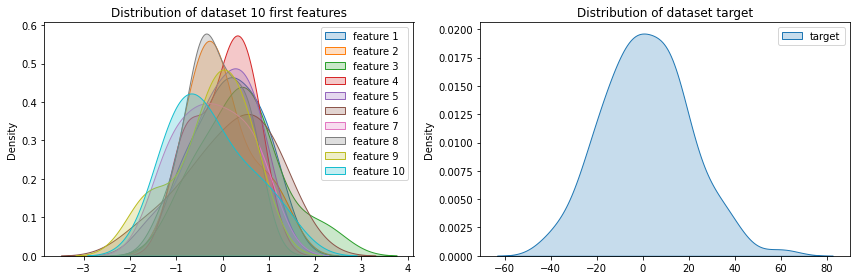

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4), tight_layout=True)

for i in range(X[:, :10].shape[1]):
    sns.kdeplot(X[i], shade=True, label=f'feature {i + 1}', ax=ax[0])
ax[0].legend()
ax[0].set_title('Distribution of dataset 10 first features')

sns.kdeplot(y, shade=True, label='target', ax=ax[1])
ax[1].legend()
ax[1].set_title('Distribution of dataset target');

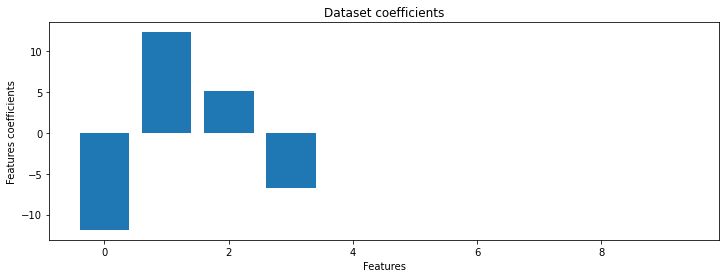

In [7]:
plt.figure(figsize=(12,4))
plt.bar(range(coefs.size), coefs)
plt.xlabel('Features')
plt.ylabel('Features coefficients')
plt.title('Dataset coefficients');

### 4) Constructing the models

In [8]:
X_t = T.shared(X)

In [9]:
bayesian_lasso = bayesian_lasso_regression(X, y)

In [17]:
CHAINS = 3

SAMPLE_KWARGS = {
    'cores': CHAINS,
    'target_accept': 0.99,
    'max_treedepth': 15,
    'random_seed': [args['seed'] + i for i in range(CHAINS)],
    'return_inferencedata': True
}

with bayesian_lasso:
    trace = pm.sample(**SAMPLE_KWARGS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [beta_0, beta, lambda, sigma]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 30 seconds.


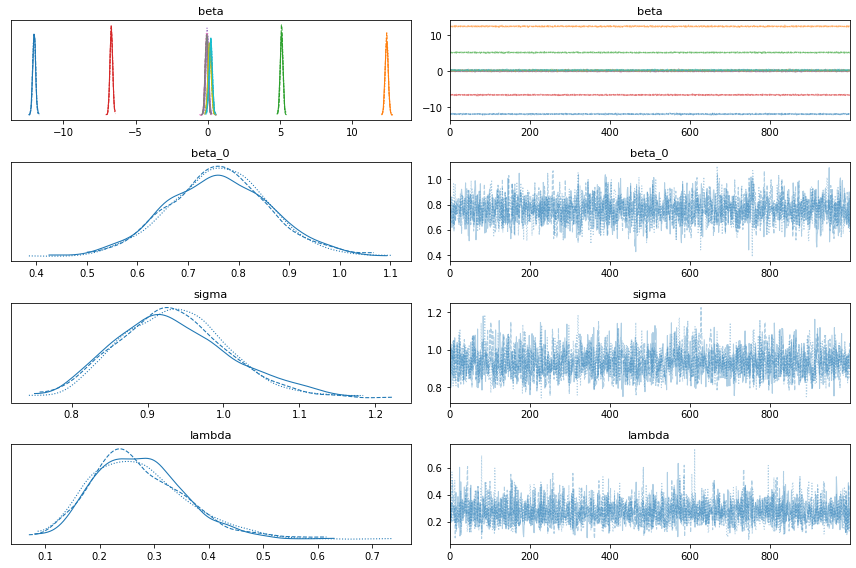

In [18]:
pm.plot_trace(trace)
plt.tight_layout();

In [19]:
trace_summary = pm.summary(trace, round_to=2)

In [20]:
beta_idx = [idx for idx in trace_summary.index if idx.startswith('beta')]
beta_coefs = trace_summary.loc[beta_idx, 'mean']

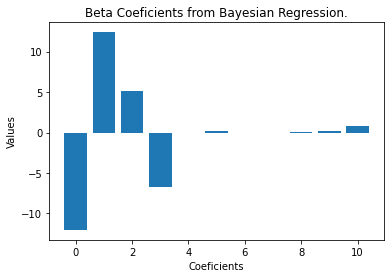

In [21]:
plt.bar(range(beta_coefs.size), beta_coefs)
plt.title('Beta Coeficients from Bayesian Regression.')
plt.xlabel('Coeficients')
plt.ylabel('Values');

In [22]:
trace_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-12.03,0.10,-12.21,-11.84,0.0,0.0,2361.02,2011.52,1.0
beta[1],12.39,0.11,12.19,12.59,0.0,0.0,2416.23,2243.72,1.0
beta[2],5.11,0.10,4.93,5.28,0.0,0.0,2804.80,2200.33,1.0
beta[3],-6.69,0.09,-6.87,-6.51,0.0,0.0,2613.45,2250.58,1.0
beta[4],-0.04,0.10,-0.23,0.14,0.0,0.0,3044.31,2243.49,1.0
beta[5],0.17,0.12,-0.04,0.39,0.0,0.0,2624.17,2450.52,1.0
beta[6],-0.09,0.10,-0.27,0.09,0.0,0.0,2949.90,2343.67,1.0
beta[7],-0.09,0.10,-0.25,0.11,0.0,0.0,2281.64,2196.32,1.0
beta[8],0.12,0.11,-0.10,0.32,0.0,0.0,2421.52,2108.06,1.0
beta[9],0.20,0.11,-0.01,0.40,0.0,0.0,2613.08,2297.93,1.0
